In [ ]:
# next steps: design cnn lstm in a bayesian way make new plot and make sure evrything is correct  

In [1]:
pip install pyro-ppl

  Obtaining dependency information for pyro-ppl from https://files.pythonhosted.org/packages/f2/93/59bced321ede6eeb60061f156df8aae3f4832127fe97f4e86c567ad3b9cc/pyro_ppl-1.8.6-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 17.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/1b/0f/77716aa9dd84bb1aa5e93c87122af1de89697b6231f6d01d58d4e7c03c14/yfinance-0.2.36-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 6.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=272555 sha256=ba25c26e092526f0837ed8bf9601a792a893014992ee75e3b75397228970f1f3
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [3]:
 pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
#imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
import scipy
import torch.nn.functional as nnf
from torch.optim import SGD 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import yfinance as yf
import matplotlib.pyplot as plt
import time
import fastprogress
import seaborn as sns
from pyro.nn import PyroModule, PyroSample
from sklearn.model_selection import train_test_split

In [6]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix >= len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def multi_time(data, n_input, n_out):
    
    #train = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    X,y = list(), list()
    in_start= 0
    
    for i in range(len(data)):
        
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
            in_start +=1
    return np.array(X), np.array(y)

        
    

def data_processing(tickers,start, end,  n_steps=1, target = None, multi_step= False, n_input=None, n_out = None):
    
    #tickers: a list of symbols to retrieve from stock market
    # start: starting date
    # end: ending date
    # target: dependent variable
    # n_steps: how many steps should be used to forecast
    # n_input: integer how many days used to make prediction
    # n_out: for how many days to predict
    
    
    data_list = []
   
    
    for symbol in tickers:
        stock_data = yf.download(symbol, start=start, end=end)
        data_close = stock_data.loc[:,"Close"]
        data_norm = (data_close - min(data_close)) / (max(data_close)-min(data_close)) #normalize
        data = data_norm.values.reshape((len(data_norm),1))
        data_list.append(np.array(data))
    
    if target is not None:
        target_data = yf.download(target, start=start, end=end)
        target_close = target_data.loc[:,"Close"]
        target_norm = (target_close - min(target_close)) / (max(target_close)-min(target_close))
        target = target_norm.values.reshape((len(target_norm),1))
      
        stacked_data = np.concatenate(data_list, axis=0)
        dataset = np.append(stacked_data,target ,axis=1)
    
    else:
        dataset = np.concatenate(data_list, axis=0)
        
   
    
    if multi_step and n_input is not None and n_out is not None:
        
        X,y = multi_time(dataset, n_input, n_out)
        
    else:
        
        X,y= split_sequences(dataset, n_steps)
    
    return X,y



In [7]:
X,y= data_processing(['CL=F'],"2022-08-23","2024-01-10",multi_step =True, n_input=60, n_out = 30)
print(X.squeeze().shape, y.shape)
X = X.squeeze()
print(X[1])
print(y[1])

[*********************100%%**********************]  1 of 1 completed

(259, 60) (259, 30)
[0.92996358 0.85166816 0.86950763 1.         0.82259656 0.75355144
 0.6564255  0.66501493 0.66534511 0.50214742 0.55500498 0.66237199
 0.69507757 0.6795506  0.71820292 0.60654106 0.6068715  0.62735391
 0.58506761 0.53518343 0.55335308 0.39643206 0.32936901 0.38850348
 0.50908495 0.47869189 0.42120906 0.5579781  0.65345213 0.69441696
 0.71721163 0.85563257 0.80574813 0.74694408 0.67822913 0.73901551
 0.6233895  0.61843405 0.53121901 0.62140742 0.63561291 0.60488942
 0.58936245 0.61380903 0.69937241 0.73802447 0.69904198 0.65378256
 0.71456894 0.76841754 0.70796159 0.85464153 0.82755202 0.73240841
 0.63065746 0.65180048 0.73406006 0.63197893 0.66666658 0.62272864]
[0.49223652 0.44070043 0.42913788 0.46944159 0.3700034  0.31516351
 0.34687805 0.37859258 0.45622739 0.47836146 0.43739688 0.33663697
 0.24810047 0.17409989 0.15592998 0.14139406 0.21242152 0.28576149
 0.34819952 0.30954745 0.24942194 0.27915439 0.30888659 0.38156595
 0.35513705 0.42352157 0.42253053 0.40370

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
X, y, test_size=0.1, random_state=42, shuffle = False)




In [9]:
class myDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [10]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],y_train.shape[1],1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test.reshape(y_test.shape[0],y_test.shape[1],1)).float()

In [32]:
train_data = myDataset(x_train.reshape(x_train.shape[0],x_train.shape[1],1),y_train)
test_data = myDataset(x_test.reshape(x_test.shape[0],x_test.shape[1],1),y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=10,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class ts_CNN(nn.Module):
    
    def __init__(self):
        super(ts_CNN, self).__init__()
        
        self.feature= nn.Sequential(
        nn.Conv1d(in_channels = 3, out_channels=64, kernel_size = 1),
        nn.ReLU(),
        )
        
        self.result = nn.Sequential(
        nn.Linear(1*64,50),
        nn.ReLU(),
        nn.Linear(50,1))
        
    def forward(self,x):
        
        x = self.feature(x)
        x = torch.flatten(x,1)
        x = self.result(x)
        
        return x.float()

In [13]:
import pyro.distributions as dist
from pyro.nn import PyroSample
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1,prior_scale=0):
        super().__init__()
        assert in_dim > 0 and out_dim > 0 
        #self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        self.layer_1 = PyroModule[nn.Conv1d](in_channels = 60, out_channels = 64, kernel_size = 3, padding = 'same')
        self.activation = PyroModule[nn.ReLU]()
        self.linear_1 = PyroModule[nn.Linear](64, 50)
        self.linear_2 = PyroModule[nn.Linear](50,30)
        
        self.layer_1.weight = PyroSample(dist.Normal(0, 1).expand([64,60,1]).to_event(3))
        self.layer_1.bias = PyroSample(dist.Normal(0, 1).expand([64]).to_event(1))
        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([50,64]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([50]).to_event(1))
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,50]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
    
    def forward(self, x, y = None):
        
        x = self.activation(self.layer_1(x))
        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        mu = self.linear_2(x)
        #print(mu.shape)
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1)) 
        
        if y is not None:
            y = torch.flatten(y,1)
        
        with pyro.plate("data", x.shape[0]):
            
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
            #print(obs)
            #print(obs.shape)
        return mu
        


In [54]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange

pyro.clear_param_store()

model = BNN()
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 13000
progress_bar = trange(num_epochs)


for epoch in progress_bar:
    loss = 0
    for batch_id, data in enumerate(train_loader):
        loss += svi.step(data[0], data[1])
    progress_bar.set_postfix(loss=f"{loss / len(x_train):.3f}")


  0%|          | 0/13000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
from pyro.infer import Predictive
predictive = Predictive(model, guide=mean_field_guide, num_samples=1000)
pred_cnn= []
plus_error_cnn = []
minus_error_cnn = []
real = []

for batch_id, data in enumerate(test_loader):
        preds = predictive(data[0])
        y_std = preds['obs'][:,0,:].detach().numpy().std(axis=0, ddof=1)
        y_preds = preds['obs'][:,0,:].detach().numpy().sum(axis=0)/1000
        y_real = data[1]
        real.append(y_real)
        plus_error_cnn.append(y_preds - 2* y_std)
        minus_error_cnn.append(y_preds + 2* y_std)
        pred_cnn.append(y_preds)

In [ ]:
# funktioniert nicht
num_samples = 10
def predict(x):
    sampled_models = [mean_field_guide(None, None) for _ in range(num_samples)]
    print(sampled_models)
    yhats = [model(x) for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return mean

predict(x_test[0])

In [ ]:
# fürs normale CNN
model.eval()
prediction = []
batch_size = 2
iterations =  int(inputs.shape[0]/2)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float().to(device))
    prediction.append(preds.detach().cpu().tolist())

In [50]:
pred_cnn[0]

array([0.3819187 , 0.34115702, 0.29736117, 0.41317642, 0.3872858 ,
       0.301338  , 0.38889477, 0.3354326 , 0.3303675 , 0.3963677 ,
       0.33207226, 0.3490229 , 0.3509581 , 0.41809878, 0.43774244,
       0.3701905 , 0.39402306, 0.3474202 , 0.34045574, 0.37075475,
       0.38936815, 0.3878279 , 0.34401783, 0.38346517, 0.36294666,
       0.3529098 , 0.3400459 , 0.33233634, 0.29783955, 0.30392095],
      dtype=float32)

In [20]:
real

[tensor([[[0.6194],
          [0.5616],
          [0.6161],
          [0.5441],
          [0.6211],
          [0.5144],
          [0.4718],
          [0.4526],
          [0.5193],
          [0.4549],
          [0.4651],
          [0.3512],
          [0.2838],
          [0.2973],
          [0.3446],
          [0.3806],
          [0.3806],
          [0.3277],
          [0.2035],
          [0.3023],
          [0.3588],
          [0.3644],
          [0.3423],
          [0.3175],
          [0.2907],
          [0.2683],
          [0.3195],
          [0.3674],
          [0.3046],
          [0.2422]]]),
 tensor([[[0.5616],
          [0.6161],
          [0.5441],
          [0.6211],
          [0.5144],
          [0.4718],
          [0.4526],
          [0.5193],
          [0.4549],
          [0.4651],
          [0.3512],
          [0.2838],
          [0.2973],
          [0.3446],
          [0.3806],
          [0.3806],
          [0.3277],
          [0.2035],
          [0.3023],
          [0.3588

In [51]:
prediction = []
truth = []
plus_error = []
minus_error = []

for i in range(len(pred_cnn)):
    if i==(len(pred_cnn)-1):
        for j in range(len(pred_cnn[i])):
            prediction.append(pred_cnn[i][j])
            truth.append(real[i][0][j].numpy())
            plus_error.append(plus_error_cnn[i][j])
            minus_error.append(minus_error_cnn[i][j])
    else:
        prediction.append(pred_cnn[i][0])
        truth.append(real[i][0][0].numpy())
        plus_error.append(plus_error_cnn[i][0])
        minus_error.append(minus_error_cnn[i][0])
        


In [24]:
prediction

[7.844189,
 2.7643,
 5.49622,
 -2.42147,
 3.7234833,
 2.1118774,
 -11.512384,
 6.890537,
 -1.1390604,
 -9.801802,
 -6.9383745,
 -2.2739754,
 1.4849029,
 -0.4926555,
 -0.98096687,
 9.529262,
 -1.9941049,
 4.916704,
 5.1137023,
 4.0650682,
 -2.1994393,
 -5.5490522,
 -0.3202483,
 2.4032521,
 6.689696,
 1.625105,
 3.0173209,
 9.344391,
 6.622963,
 -3.4977114,
 1.7086995,
 0.74434805,
 13.704061,
 -2.890025,
 -8.056735,
 -2.727709,
 -8.96268,
 15.209597,
 7.9811153,
 -0.7371759,
 -0.9939428,
 -5.142938,
 7.125134,
 -6.8880997,
 -6.474001,
 8.493874,
 1.5541619,
 7.692176,
 5.757927,
 -1.709605,
 -4.786463,
 -1.4103091,
 1.9780536,
 8.49934,
 9.3887415]

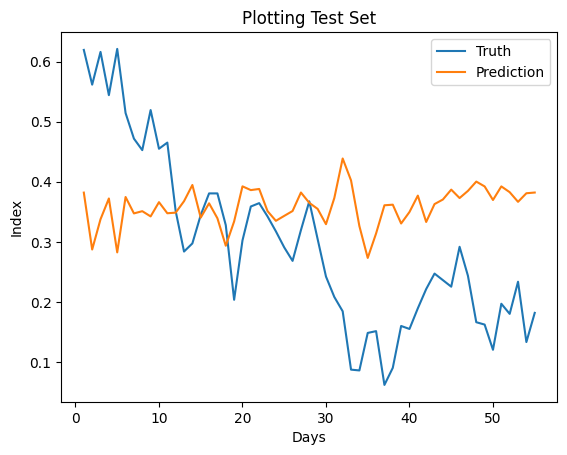

In [53]:
from matplotlib import pyplot as plt
import numpy as np 

x = np.arange(1, 56)

plt.plot(x, truth, label='Truth')
plt.plot(x, prediction, label='Prediction')

#plt.plot(x, plus_error)
#plt.plot(x, minus_error)

#plt.fill_between(x, plus_error, minus_error, color='green', alpha=0.3)

plt.xlabel('Days')
plt.ylabel('Index')
plt.title('Plotting Test Set')
plt.legend()

plt.show()

In [39]:
preds['obs'][499]

tensor([[0.4550, 0.6230, 0.5328, 0.3277, 0.7926, 0.5648, 0.4590, 0.5583, 0.6486,
         0.4709, 0.7602, 0.6444, 0.5299, 0.3512, 0.5774, 0.6365, 0.8183, 0.7430,
         0.6366, 0.6940, 0.5952, 0.6400, 0.3827, 0.5833, 0.3735, 0.4852, 0.6309,
         0.5082, 0.3566, 0.6108],
        [0.3114, 0.4594, 0.4931, 0.4653, 0.6427, 0.6773, 0.2999, 0.6703, 0.6062,
         0.5839, 0.5647, 0.5714, 0.4332, 0.5860, 0.7183, 0.6549, 0.4911, 0.5934,
         0.5281, 0.3996, 0.7018, 0.6649, 0.8272, 0.6784, 0.5618, 0.5350, 0.7601,
         0.6649, 0.7194, 0.5150]])

In [41]:
preds['obs'][:,0,:].detach().numpy().sum(axis=0)/500

array([0.5337707 , 0.5058664 , 0.5882776 , 0.5084146 , 0.60286576,
       0.58878523, 0.57005054, 0.54155266, 0.58992606, 0.51274663,
       0.53840595, 0.5135027 , 0.49600688, 0.52959734, 0.5952513 ,
       0.5252082 , 0.537766  , 0.5381802 , 0.5428346 , 0.5441912 ,
       0.5363558 , 0.61066765, 0.54113305, 0.6158426 , 0.54043883,
       0.5187796 , 0.5377378 , 0.6215734 , 0.51009625, 0.6015029 ],
      dtype=float32)

In [29]:
for batch_id, data in enumerate(test_loader):
    true = data[1]
    print(true)
    break

tensor([[[0.6194],
         [0.5616],
         [0.6161],
         [0.5441],
         [0.6211],
         [0.5144],
         [0.4718],
         [0.4526],
         [0.5193],
         [0.4549],
         [0.4651],
         [0.3512],
         [0.2838],
         [0.2973],
         [0.3446],
         [0.3806],
         [0.3806],
         [0.3277],
         [0.2035],
         [0.3023],
         [0.3588],
         [0.3644],
         [0.3423],
         [0.3175],
         [0.2907],
         [0.2683],
         [0.3195],
         [0.3674],
         [0.3046],
         [0.2422]]])


In [41]:
print(np.subtract(true.detach().numpy(),y_pred))

[[[ 4.22698259e-01  3.64543647e-01  2.91960955e-01  4.17266250e-01
    3.08550030e-01  2.75494069e-01  3.42824966e-01  4.77227271e-01
    1.96145833e-01  2.47617841e-01  3.75650704e-01  3.27167183e-01
    1.99643254e-01  2.78188229e-01  3.76788348e-01  2.81925619e-01
    2.46478707e-01  3.38134497e-01  2.83764541e-01  3.58020872e-01
    3.49105954e-01  3.81298929e-01  3.79619777e-01  2.83625543e-01
    3.17340642e-01  1.99767053e-01  3.94866198e-01  4.31371987e-01
    2.79483974e-01  3.15039337e-01]
  [ 3.64885271e-01  3.06730658e-01  2.34147966e-01  3.59453261e-01
    2.50737041e-01  2.17681080e-01  2.85011977e-01  4.19414282e-01
    1.38332844e-01  1.89804852e-01  3.17837715e-01  2.69354194e-01
    1.41830266e-01  2.20375240e-01  3.18975359e-01  2.24112630e-01
    1.88665718e-01  2.80321509e-01  2.25951552e-01  3.00207883e-01
    2.91292965e-01  3.23485941e-01  3.21806788e-01  2.25812554e-01
    2.59527653e-01  1.41954064e-01  3.37053210e-01  3.73558998e-01
    2.21670985e-01  2.5722

In [28]:
y_std = preds['obs'][:,0,:].detach().numpy().std(axis=0, ddof=1)
y_pred = preds['obs'][:,0,:].detach().numpy().sum(axis=0)/500
print(y_pred, y_std)

plus_error = y_pred - 2* y_std
minus_error = y_pred + 2* y_std
#x_line = range(0,46)


[0.19672681 0.2548814  0.3274641  0.20215882 0.31087503 0.343931
 0.2766001  0.1421978  0.42327923 0.37180722 0.24377434 0.29225788
 0.4197818  0.34123683 0.24263671 0.33749944 0.37294635 0.28129056
 0.33566052 0.2614042  0.2703191  0.23812613 0.23980527 0.33579952
 0.30208442 0.419658   0.22455886 0.18805307 0.33994108 0.30438572] [1.0771255  1.3424342  0.92923725 1.0472139  0.91685736 1.4471279
 1.187489   1.1476533  1.2968284  1.1437916  0.98991895 1.0233359
 1.1006299  1.0124598  0.9842362  1.4385482  0.9633759  1.0554849
 1.1180553  1.120063   1.0988381  1.2130543  1.0688981  0.92041373
 1.0779586  1.9291072  1.354278   1.7015736  1.3861715  1.0786201 ]


In [27]:

print(plus_error)
print(minus_error)

[-1.9575243 -2.429987  -1.5310104 -1.892269  -1.5228397 -2.550325
 -2.098378  -2.1531088 -2.1703775 -1.9157759 -1.7360636 -1.754414
 -1.781478  -1.6836827 -1.7258357 -2.539597  -1.5538055 -1.8296793
 -1.9004502 -1.9787217 -1.9273571 -2.1879826 -1.897991  -1.505028
 -1.8538327 -3.4385564 -2.483997  -3.215094  -2.432402  -1.8528545]
[2.350978  2.9397497 2.1859386 2.2965868 2.1445897 3.2381868 2.6515782
 2.4375045 3.016936  2.6593904 2.2236123 2.3389297 2.6210418 2.3661563
 2.2111092 3.2145958 2.299698  2.3922603 2.5717711 2.5015302 2.4679952
 2.6642346 2.3776014 2.176627  2.4580016 4.2778726 2.9331148 3.5912004
 3.112284  2.4616258]


In [49]:
target_y= true.detach().numpy()
print(target_y, y_pred)

[[[0.61942506]
  [0.56161207]
  [0.61612153]
  [0.544103  ]
  [0.621077  ]
  [0.51437056]
  [0.4717541 ]
  [0.45259342]
  [0.51932603]
  [0.45490593]
  [0.46514702]
  [0.3511729 ]
  [0.2837794 ]
  [0.29732403]
  [0.34456554]
  [0.3805749 ]
  [0.3805749 ]
  [0.32771736]
  [0.20350191]
  [0.3022795 ]
  [0.35877103]
  [0.3643871 ]
  [0.34225303]
  [0.31747603]
  [0.29071695]
  [0.26825246]
  [0.31945837]
  [0.36736047]
  [0.304592  ]
  [0.24215397]]] [0.19672681 0.2548814  0.3274641  0.20215882 0.31087503 0.343931
 0.2766001  0.1421978  0.42327923 0.37180722 0.24377434 0.29225788
 0.4197818  0.34123683 0.24263671 0.33749944 0.37294635 0.28129056
 0.33566052 0.2614042  0.2703191  0.23812613 0.23980527 0.33579952
 0.30208442 0.419658   0.22455886 0.18805307 0.33994108 0.30438572]


In [72]:
y_train.numpy().unsqueeze().tolist()

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

ValueError: x and y can be no greater than 2D, but have shapes (5202,) and (5202, 30, 1)

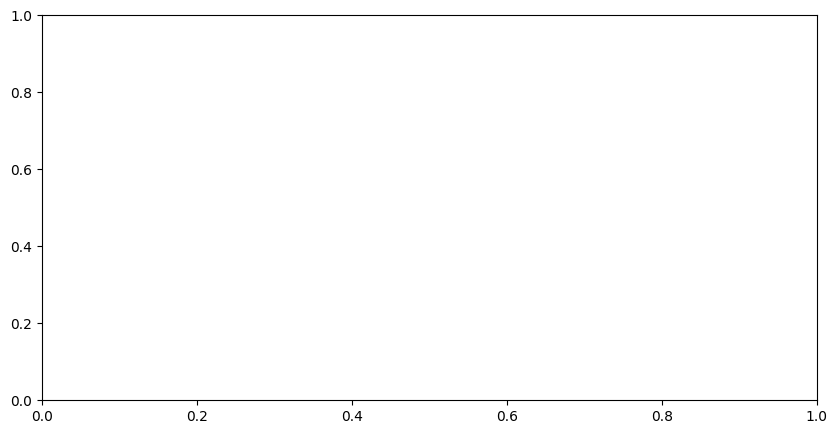

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(y_train.numpy().tolist())),y_train.numpy().tolist())
ax.plot(y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
ax.plot(target_y, '-', linewidth=3, color="r", label="predictive mean")
ax.fill_between(plus_error, minus_error, alpha=0.6, color='#86cfac', zorder=5)